# Named Entity Recognition on Queries

## 1. Introduction

This notebook is the implementation for the NLP project: Named Entity Recognition on Queries.<br/>
We presented two experiment on the named entity recognition, one is the word + char level NN, another one is the word level baseline model.By comparing these two model, we extract insight for the choice of architecture of NER on query and infered the reason behind it.

## 2. Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras_contrib.layers import CRF

Using TensorFlow backend.


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [3]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [4]:
import urllib

## 2.1 Data preprocessing

we import the data from https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio which is the MIT restaurant query corpus.

In [5]:

import requests

link = "https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio"

In [6]:
#for mit data
import requests
import pandas as pd
import io

urlData = requests.get(link).content
rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

In [7]:
data=rawData["O	a"].str.split('\t', 1, expand=True)

In [8]:
# the orignial data
data

,0,1
0,B-Rating,four
1,I-Rating,star
2,O,restaurant
3,B-Location,with
4,I-Location,a
5,B-Amenity,bar
6,O,any
7,B-Cuisine,asian
8,O,cuisine
9,B-Location,around


In [9]:
data.columns

RangeIndex(start=0, stop=2, step=1)

In [10]:
data.columns = data.columns.astype(str)

In [11]:
data.columns

Index(['0', '1'], dtype='object')

rename the colums to tag and word

In [12]:
df2 = data.rename(index=str, columns={'0':'Tag', '1':'Word'})

In [13]:
df2

,Tag,Word
0,B-Rating,four
1,I-Rating,star
2,O,restaurant
3,B-Location,with
4,I-Location,a
5,B-Amenity,bar
6,O,any
7,B-Cuisine,asian
8,O,cuisine
9,B-Location,around


fixing the missing valuues with fillna

In [14]:
def fix_na_value(df):
    df = df.fillna(method="ffill")
    return df

In [14]:

df= fix_na_value(df2)
df.tail()

,Tag,Word
14250,O,me
14251,O,with
14252,O,some
14253,B-Dish,onion
14254,I-Dish,rings


In [15]:
#check the shape
df.shape

(14255, 2)

get word and tag

In [ ]:
def retr_words_tags(df):
    
    #for words
    words = list(set(df["Word"].values))
    
    #adding extra for padding
    words.append("ENDPAD")
    n_words = len(words)
    
    
    #for tags
    tags = list(set(df["Tag"].values))
    n_tags = len(tags)
    
    
    return words, tags, n_words, n_tags

In [16]:
words, tags, n_words, n_tags= retr_words_tags(df)

total words number: 1632
total tags number: 17


In [17]:

def read_data(file_path):
    
    #first layer for very sentence
    tokens = []
    tags = []
    
    #second layer for every word
    qr_tokens = []
    qr_tags = []
    
    #loop
    for line in io.StringIO(requests.get(link).content.decode('utf-8')):
        line = line.strip()
        if not line:
            if qr_tokens:
                tokens.append(qr_tokens)
                tags.append(qr_tags)
            qr_tokens = []
            qr_tags = []
        else:
            tag, token = line.split()
            qr_tokens.append(token)
            qr_tags.append(tag)
            
    return tokens, tags

get the tokens and tags

In [18]:
train_tokens, train_tags = read_data(df)

In [19]:
#train tokens
train_tokens

[['a', 'four', 'star', 'restaurant', 'with', 'a', 'bar'],
 ['any', 'asian', 'cuisine', 'around'],
 ['any', 'bbq', 'places', 'open', 'before', '5', 'nearby'],
 ['any', 'dancing', 'establishments', 'with', 'reasonable', 'pricing'],
 ['any', 'good', 'cheap', 'german', 'restaurants', 'nearby'],
 ['any', 'good', 'ice', 'cream', 'parlors', 'around'],
 ['any',
  'good',
  'place',
  'to',
  'get',
  'a',
  'pie',
  'at',
  'an',
  'affordable',
  'price'],
 ['any', 'good', 'vegan', 'spots', 'nearby'],
 ['any', 'mexican', 'places', 'have', 'a', 'tameles', 'special', 'today'],
 ['any',
  'place',
  'along',
  'the',
  'road',
  'has',
  'a',
  'good',
  'beer',
  'selection',
  'that',
  'also',
  'serves',
  'ribs'],
 ['any', 'places', 'around', 'here', 'that', 'has', 'a', 'nice', 'view'],
 ['any',
  'reasonably',
  'priced',
  'indian',
  'restaurants',
  'in',
  'the',
  'theater',
  'district'],
 ['any', 'restaurants', 'open', 'right', 'now'],
 ['any', 'restaurants', 'that', 'still', 'allow

length of tokens

In [20]:
len(train_tokens)

1521

shape of the whole df

In [22]:
df.shape

(14255, 2)

vectorize word and tag

In [23]:
#word to index using dictionary
word2idx = {w: i + 1 for i, w in enumerate(words)}

In [24]:
# showed the dict of word
word2idx

{'lane': 1,
 'mister': 2,
 'smokers': 3,
 'central': 4,
 'portugeese': 5,
 'staff': 6,
 'mex': 7,
 'vegetables': 8,
 'chickfila': 9,
 'eastern': 10,
 'kettle': 11,
 'route': 12,
 'buffets': 13,
 'churchs': 14,
 'logans': 15,
 'make': 16,
 'himalayan': 17,
 'moderately': 18,
 'cabbage': 19,
 'ashlannd': 20,
 'queen': 21,
 'been': 22,
 'lot': 23,
 'alans': 24,
 'ten': 25,
 'naugles': 26,
 'jackets': 27,
 'pizzahut': 28,
 'evans': 29,
 'egg': 30,
 'kilmarnock': 31,
 'comfortable': 32,
 'steack': 33,
 'nearest': 34,
 'hello': 35,
 'frequent': 36,
 'korean': 37,
 'non': 38,
 'st': 39,
 'baltimore': 40,
 'portions': 41,
 'johnsons': 42,
 'hotels': 43,
 'feel': 44,
 'pedicures': 45,
 'lobster': 46,
 'vietnamese': 47,
 'bread': 48,
 'would': 49,
 'wildhorse': 50,
 'tai': 51,
 'drinks': 52,
 'free': 53,
 'beef': 54,
 'nears': 55,
 'fatty': 56,
 'wine': 57,
 'cash': 58,
 'pastry': 59,
 'donut': 60,
 'nossa': 61,
 'fancy': 62,
 'taco': 63,
 'appetizers': 64,
 'crying': 65,
 'having': 66,
 'fi': 6

using digits to vectorize the token

In [26]:
X = [[word2idx[w] for w in i] for i in train_tokens]

length of token vec

In [27]:
len(X)

1521

In [28]:
# show the word
X

[[1135, 661, 829, 1056, 769, 1135, 533],
 [1447, 346, 1177, 1414],
 [1447, 1510, 917, 1186, 1034, 534, 920],
 [1447, 358, 891, 769, 379, 525],
 [1447, 614, 1280, 962, 1502, 920],
 [1447, 614, 1424, 779, 180, 1414],
 [1447, 614, 142, 1390, 675, 1135, 847, 110, 438, 188, 1215],
 [1447, 614, 1160, 223, 920],
 [1447, 1228, 917, 770, 1135, 1240, 71, 692],
 [1447,
  142,
  520,
  1349,
  958,
  1195,
  1135,
  614,
  1020,
  1339,
  503,
  445,
  1133,
  1174],
 [1447, 917, 1414, 1125, 503, 1195, 1135, 245, 278],
 [1447, 1272, 593, 458, 1502, 103, 1349, 253, 588],
 [1447, 1502, 1186, 1209, 1412],
 [1447, 1502, 503, 1203, 1423, 1216],
 [1447,
  1267,
  1414,
  82,
  925,
  772,
  1458,
  1135,
  141,
  1573,
  82,
  1349,
  221,
  1524,
  1003,
  1478,
  1234],
 [836, 948, 1349, 1255],
 [836, 1186, 1181, 620, 769, 379, 221],
 [1524, 338, 441, 103, 737, 463, 1594, 1607],
 [1524, 565, 827, 1245, 661, 355, 1245, 1040, 1539, 1411, 110, 1377, 899],
 [1524, 1349, 559, 110, 408, 152, 636, 786, 813, 

we use the max_len for 15 considering the length of query is pretty short. We consider it as a hyperparamenter for simplicity. We can also use the distribution of it to calculate the max len.

In [29]:
max_len = 15

In [30]:
#padding for word
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
X

array([[1135,  661,  829, ..., 1631, 1631, 1631],
       [1447,  346, 1177, ..., 1631, 1631, 1631],
       [1447, 1510,  917, ..., 1631, 1631, 1631],
       ...,
       [1341, 1349,  104, ..., 1631, 1631, 1631],
       [1341,  515, 1052, ..., 1099, 1384, 1142],
       [1373,  981, 1519, ..., 1631, 1631, 1631]], dtype=int32)

In [31]:
X.shape

(1521, 15)

Now we work for tags as lable

In [32]:
#dict
tag2idx = {t: i for i, t in enumerate(tags)}

#vectorize
y = [[tag2idx[w] for w in i] for i in train_tags]

#padding
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

Now we work for chars as another feature

In [33]:
#char

chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


41


In [34]:
#show char
chars

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'D',
 'E',
 'N',
 'P',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [35]:
#dictionary of char
char2idx = {c: i +1  for i, c in enumerate(chars)}
# adding 0 for padding
char2idx["UNPAD"] = 0

In [36]:
#dict
char2idx

{'x': 1,
 'P': 2,
 '8': 3,
 'D': 4,
 'k': 5,
 '1': 6,
 'n': 7,
 '7': 8,
 'c': 9,
 'N': 10,
 'u': 11,
 'g': 12,
 'z': 13,
 'd': 14,
 '5': 15,
 'e': 16,
 'i': 17,
 'y': 18,
 'o': 19,
 'p': 20,
 'f': 21,
 '6': 22,
 '9': 23,
 'l': 24,
 'b': 25,
 'E': 26,
 'm': 27,
 'r': 28,
 '0': 29,
 'v': 30,
 'j': 31,
 'A': 32,
 'a': 33,
 '2': 34,
 'h': 35,
 'w': 36,
 '4': 37,
 't': 38,
 '3': 39,
 'q': 40,
 's': 41,
 'UNPAD': 0}

we set the max len of char to 8 because most word has less than 8 chars in queries. This is also a hyperparameter and we also optimize it by distribution.

In [ ]:
max_len_char = 8

In [37]:
#vectorize the char
X_char = []
for sentence in train_tokens:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("UNPAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [38]:
X_char

[array([[33,  0,  0,  0,  0,  0,  0,  0],
        [21,  0,  0,  0,  0,  0,  0,  0],
        [41,  0,  0,  0,  0,  0,  0,  0],
        [28,  0,  0,  0,  0,  0,  0,  0],
        [36,  0,  0,  0,  0,  0,  0,  0],
        [33,  0,  0,  0,  0,  0,  0,  0],
        [25,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[33,  0,  0,  0,  0,  0,  0,  0],
        [33,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  0,  0,  0,  0,  0,  0,  0],
        [33,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,

make char into numpy array

In [39]:
X_char=np.array(X_char)

check the shape of char

In [40]:
X_char.shape

(1521, 15, 8)

check the shape of word

In [41]:
X.shape

(1521, 15)

split the data to train and test

In [42]:
X_train, X_test, X_train_char, X_test_char, y_train, y_test = train_test_split(X, X_char, y,test_size=0.3)

## 2.2 Word +Char NN model for NER

In [43]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras import regularizers
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [44]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
drop0=Dropout(0.9, name='bidirectional_dropout_enc0')(emb_char)


# character LSTM-first lstm
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.8))(drop0)

drop1 = Dropout(0.9, name='bidirectional_dropout_enc1')(char_enc)

# second biLSTM
#concate
x = concatenate([emb_word, drop1])
#main drop
x = SpatialDropout1D(0.8)(x)
#bilstm
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.8))(x)

#drop
drop2 = Dropout(0.8, name='bidirectional_dropout_enc2')(main_lstm)

tdb = TimeDistributed(Dense(n_tags, activation="softmax",kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l1(0.05)))(drop2)


# crf layer

crf = CRF(n_tags,sparse_target=False)  # CRF layer
out = crf(tdb)  # output

model = Model([word_in, char_in], out)

compile th maodel and summary

In [45]:
model.compile(optimizer="rmsprop",loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/Users/jianwenliu/anaconda3/envs/deepAI/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/jianwenliu/anaconda3/envs/deepAI/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15, 8)        0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 8, 10)    430         input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_dropout_enc0 (Dro (None, 15, 8, 10)    0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
time_distr

make lable into array

In [46]:
np.array(y_train).shape

(1064, 15, 17)

Train the word+char NN model

In [47]:
history_char_word = model.fit([X_train,
                     np.array(X_train_char).reshape((len(X_train_char), max_len, max_len_char))],
                    np.array(y_train).reshape(len(y_train), max_len, 17),
                    batch_size=64, epochs=1000, validation_split=0.1, verbose=1)


Train on 957 samples, validate on 107 samples
Epoch 1/1000
957/957 [==============================] - 6s 6ms/step - loss: 54.4154 - crf_viterbi_accuracy: 0.0321 - val_loss: 48.1918 - val_crf_viterbi_accuracy: 0.0983
Epoch 2/1000
957/957 [==============================] - 1s 1ms/step - loss: 54.0561 - crf_viterbi_accuracy: 0.1839 - val_loss: 47.8765 - val_crf_viterbi_accuracy: 0.3159
Epoch 3/1000
957/957 [==============================] - 1s 1ms/step - loss: 53.7619 - crf_viterbi_accuracy: 0.3575 - val_loss: 47.5828 - val_crf_viterbi_accuracy: 0.5084
Epoch 4/1000
957/957 [==============================] - 1s 1ms/step - loss: 53.4993 - crf_viterbi_accuracy: 0.5031 - val_loss: 47.3268 - val_crf_viterbi_accuracy: 0.6040
Epoch 5/1000
957/957 [==============================] - 1s 1ms/step - loss: 53.2746 - crf_viterbi_accuracy: 0.5842 - val_loss: 47.1263 - val_crf_viterbi_accuracy: 0.6093
Epoch 6/1000
957/957 [==============================] - 1s 1ms/step - loss: 53.0917 - crf_viterbi_accura

Epoch 49/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.6423 - crf_viterbi_accuracy: 0.5950 - val_loss: 45.5459 - val_crf_viterbi_accuracy: 0.6093
Epoch 50/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.6309 - crf_viterbi_accuracy: 0.5955 - val_loss: 45.5340 - val_crf_viterbi_accuracy: 0.6093
Epoch 51/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.6194 - crf_viterbi_accuracy: 0.5954 - val_loss: 45.5216 - val_crf_viterbi_accuracy: 0.6093
Epoch 52/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.6079 - crf_viterbi_accuracy: 0.5970 - val_loss: 45.5101 - val_crf_viterbi_accuracy: 0.6093
Epoch 53/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.5959 - crf_viterbi_accuracy: 0.5986 - val_loss: 45.4980 - val_crf_viterbi_accuracy: 0.6093
Epoch 54/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.5856 - crf_viterbi_accuracy: 0.5998 - val_loss: 45.4898 - val_crf

Epoch 97/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.2985 - crf_viterbi_accuracy: 0.6312 - val_loss: 45.2339 - val_crf_viterbi_accuracy: 0.6646
Epoch 98/1000
957/957 [==============================] - 1s 2ms/step - loss: 51.2994 - crf_viterbi_accuracy: 0.6292 - val_loss: 45.2300 - val_crf_viterbi_accuracy: 0.6677
Epoch 99/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.2970 - crf_viterbi_accuracy: 0.6324 - val_loss: 45.2262 - val_crf_viterbi_accuracy: 0.6687
Epoch 100/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.2884 - crf_viterbi_accuracy: 0.6342 - val_loss: 45.2232 - val_crf_viterbi_accuracy: 0.6730
Epoch 101/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.2821 - crf_viterbi_accuracy: 0.6343 - val_loss: 45.2193 - val_crf_viterbi_accuracy: 0.6752
Epoch 102/1000
957/957 [==============================] - 1s 2ms/step - loss: 51.2806 - crf_viterbi_accuracy: 0.6323 - val_loss: 45.2163 - val_

957/957 [==============================] - 1s 1ms/step - loss: 51.1799 - crf_viterbi_accuracy: 0.6522 - val_loss: 45.1335 - val_crf_viterbi_accuracy: 0.6921
Epoch 145/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1727 - crf_viterbi_accuracy: 0.6576 - val_loss: 45.1295 - val_crf_viterbi_accuracy: 0.6981
Epoch 146/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1733 - crf_viterbi_accuracy: 0.6520 - val_loss: 45.1286 - val_crf_viterbi_accuracy: 0.6962
Epoch 147/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1718 - crf_viterbi_accuracy: 0.6484 - val_loss: 45.1264 - val_crf_viterbi_accuracy: 0.6962
Epoch 148/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1668 - crf_viterbi_accuracy: 0.6572 - val_loss: 45.1260 - val_crf_viterbi_accuracy: 0.6962
Epoch 149/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1667 - crf_viterbi_accuracy: 0.6547 - val_loss: 45.1228 - val_crf_viterbi_

Epoch 192/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.1182 - crf_viterbi_accuracy: 0.6704 - val_loss: 45.0855 - val_crf_viterbi_accuracy: 0.7044
Epoch 193/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.1142 - crf_viterbi_accuracy: 0.6778 - val_loss: 45.0873 - val_crf_viterbi_accuracy: 0.7046
Epoch 194/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.1139 - crf_viterbi_accuracy: 0.6707 - val_loss: 45.0834 - val_crf_viterbi_accuracy: 0.7055
Epoch 195/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.1220 - crf_viterbi_accuracy: 0.6703 - val_loss: 45.0837 - val_crf_viterbi_accuracy: 0.7044
Epoch 196/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.1158 - crf_viterbi_accuracy: 0.6738 - val_loss: 45.0822 - val_crf_viterbi_accuracy: 0.7044
Epoch 197/1000
957/957 [==============================] - 1s 2ms/step - loss: 51.1131 - crf_viterbi_accuracy: 0.6704 - val_loss: 45.0821 - v

957/957 [==============================] - 1s 1ms/step - loss: 51.0876 - crf_viterbi_accuracy: 0.6719 - val_loss: 45.0606 - val_crf_viterbi_accuracy: 0.7075
Epoch 240/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0925 - crf_viterbi_accuracy: 0.6719 - val_loss: 45.0580 - val_crf_viterbi_accuracy: 0.7075
Epoch 241/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0880 - crf_viterbi_accuracy: 0.6732 - val_loss: 45.0612 - val_crf_viterbi_accuracy: 0.7095
Epoch 242/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0838 - crf_viterbi_accuracy: 0.6773 - val_loss: 45.0604 - val_crf_viterbi_accuracy: 0.7074
Epoch 243/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0900 - crf_viterbi_accuracy: 0.6738 - val_loss: 45.0597 - val_crf_viterbi_accuracy: 0.7044
Epoch 244/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0805 - crf_viterbi_accuracy: 0.6771 - val_loss: 45.0597 - val_crf_viterbi_

Epoch 287/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0684 - crf_viterbi_accuracy: 0.6731 - val_loss: 45.0387 - val_crf_viterbi_accuracy: 0.7198
Epoch 288/1000
957/957 [==============================] - 2s 2ms/step - loss: 51.0693 - crf_viterbi_accuracy: 0.6782 - val_loss: 45.0395 - val_crf_viterbi_accuracy: 0.7222
Epoch 289/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0685 - crf_viterbi_accuracy: 0.6769 - val_loss: 45.0393 - val_crf_viterbi_accuracy: 0.7207
Epoch 290/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0578 - crf_viterbi_accuracy: 0.6879 - val_loss: 45.0393 - val_crf_viterbi_accuracy: 0.7222
Epoch 291/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0588 - crf_viterbi_accuracy: 0.6869 - val_loss: 45.0387 - val_crf_viterbi_accuracy: 0.7200
Epoch 292/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0672 - crf_viterbi_accuracy: 0.6727 - val_loss: 45.0413 - v

957/957 [==============================] - 1s 1ms/step - loss: 51.0463 - crf_viterbi_accuracy: 0.6831 - val_loss: 45.0297 - val_crf_viterbi_accuracy: 0.7240
Epoch 335/1000
957/957 [==============================] - 1s 2ms/step - loss: 51.0505 - crf_viterbi_accuracy: 0.6881 - val_loss: 45.0289 - val_crf_viterbi_accuracy: 0.7229
Epoch 336/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0474 - crf_viterbi_accuracy: 0.6863 - val_loss: 45.0274 - val_crf_viterbi_accuracy: 0.7229
Epoch 337/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0467 - crf_viterbi_accuracy: 0.6932 - val_loss: 45.0278 - val_crf_viterbi_accuracy: 0.7240
Epoch 338/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0447 - crf_viterbi_accuracy: 0.6876 - val_loss: 45.0260 - val_crf_viterbi_accuracy: 0.7217
Epoch 339/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0525 - crf_viterbi_accuracy: 0.6866 - val_loss: 45.0290 - val_crf_viterbi_

Epoch 382/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0418 - crf_viterbi_accuracy: 0.6866 - val_loss: 45.0201 - val_crf_viterbi_accuracy: 0.7169
Epoch 383/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0391 - crf_viterbi_accuracy: 0.6981 - val_loss: 45.0203 - val_crf_viterbi_accuracy: 0.7169
Epoch 384/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0340 - crf_viterbi_accuracy: 0.6895 - val_loss: 45.0223 - val_crf_viterbi_accuracy: 0.7150
Epoch 385/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0380 - crf_viterbi_accuracy: 0.6902 - val_loss: 45.0213 - val_crf_viterbi_accuracy: 0.7189
Epoch 386/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0348 - crf_viterbi_accuracy: 0.6945 - val_loss: 45.0180 - val_crf_viterbi_accuracy: 0.7217
Epoch 387/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0356 - crf_viterbi_accuracy: 0.6905 - val_loss: 45.0199 - v

957/957 [==============================] - 1s 1ms/step - loss: 51.0184 - crf_viterbi_accuracy: 0.6992 - val_loss: 45.0153 - val_crf_viterbi_accuracy: 0.7210
Epoch 430/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0286 - crf_viterbi_accuracy: 0.6925 - val_loss: 45.0143 - val_crf_viterbi_accuracy: 0.7198
Epoch 431/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0315 - crf_viterbi_accuracy: 0.6925 - val_loss: 45.0119 - val_crf_viterbi_accuracy: 0.7197
Epoch 432/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0276 - crf_viterbi_accuracy: 0.6960 - val_loss: 45.0114 - val_crf_viterbi_accuracy: 0.7240
Epoch 433/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0297 - crf_viterbi_accuracy: 0.6897 - val_loss: 45.0154 - val_crf_viterbi_accuracy: 0.7201
Epoch 434/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0277 - crf_viterbi_accuracy: 0.6946 - val_loss: 45.0149 - val_crf_viterbi_

Epoch 477/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0202 - crf_viterbi_accuracy: 0.6959 - val_loss: 45.0070 - val_crf_viterbi_accuracy: 0.7256
Epoch 478/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0152 - crf_viterbi_accuracy: 0.6986 - val_loss: 45.0069 - val_crf_viterbi_accuracy: 0.7256
Epoch 479/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0171 - crf_viterbi_accuracy: 0.6947 - val_loss: 45.0079 - val_crf_viterbi_accuracy: 0.7247
Epoch 480/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0200 - crf_viterbi_accuracy: 0.7008 - val_loss: 45.0058 - val_crf_viterbi_accuracy: 0.7217
Epoch 481/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0115 - crf_viterbi_accuracy: 0.6983 - val_loss: 45.0076 - val_crf_viterbi_accuracy: 0.7280
Epoch 482/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0148 - crf_viterbi_accuracy: 0.6967 - val_loss: 45.0060 - v

957/957 [==============================] - 1s 1ms/step - loss: 51.0157 - crf_viterbi_accuracy: 0.7011 - val_loss: 45.0050 - val_crf_viterbi_accuracy: 0.7340
Epoch 525/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0115 - crf_viterbi_accuracy: 0.7046 - val_loss: 45.0020 - val_crf_viterbi_accuracy: 0.7293
Epoch 526/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0115 - crf_viterbi_accuracy: 0.7023 - val_loss: 45.0028 - val_crf_viterbi_accuracy: 0.7293
Epoch 527/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0143 - crf_viterbi_accuracy: 0.6950 - val_loss: 45.0014 - val_crf_viterbi_accuracy: 0.7303
Epoch 528/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0075 - crf_viterbi_accuracy: 0.7028 - val_loss: 45.0034 - val_crf_viterbi_accuracy: 0.7351
Epoch 529/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0069 - crf_viterbi_accuracy: 0.6995 - val_loss: 45.0031 - val_crf_viterbi_

Epoch 572/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9979 - crf_viterbi_accuracy: 0.6983 - val_loss: 45.0000 - val_crf_viterbi_accuracy: 0.7282
Epoch 573/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0060 - crf_viterbi_accuracy: 0.7027 - val_loss: 45.0018 - val_crf_viterbi_accuracy: 0.7311
Epoch 574/1000
957/957 [==============================] - 1s 1ms/step - loss: 51.0056 - crf_viterbi_accuracy: 0.7007 - val_loss: 45.0002 - val_crf_viterbi_accuracy: 0.7331
Epoch 575/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9991 - crf_viterbi_accuracy: 0.7039 - val_loss: 45.0029 - val_crf_viterbi_accuracy: 0.7373
Epoch 576/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9994 - crf_viterbi_accuracy: 0.6997 - val_loss: 44.9994 - val_crf_viterbi_accuracy: 0.7272
Epoch 577/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9970 - crf_viterbi_accuracy: 0.7069 - val_loss: 44.9982 - v

957/957 [==============================] - 1s 1ms/step - loss: 50.9868 - crf_viterbi_accuracy: 0.7113 - val_loss: 44.9962 - val_crf_viterbi_accuracy: 0.7372
Epoch 620/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9964 - crf_viterbi_accuracy: 0.7117 - val_loss: 44.9943 - val_crf_viterbi_accuracy: 0.7293
Epoch 621/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9892 - crf_viterbi_accuracy: 0.7167 - val_loss: 44.9933 - val_crf_viterbi_accuracy: 0.7349
Epoch 622/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9941 - crf_viterbi_accuracy: 0.7011 - val_loss: 44.9962 - val_crf_viterbi_accuracy: 0.7361
Epoch 623/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9952 - crf_viterbi_accuracy: 0.7132 - val_loss: 44.9944 - val_crf_viterbi_accuracy: 0.7273
Epoch 624/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9946 - crf_viterbi_accuracy: 0.7086 - val_loss: 44.9929 - val_crf_viterbi_

Epoch 667/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9956 - crf_viterbi_accuracy: 0.7112 - val_loss: 44.9887 - val_crf_viterbi_accuracy: 0.7369
Epoch 668/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9867 - crf_viterbi_accuracy: 0.7091 - val_loss: 44.9902 - val_crf_viterbi_accuracy: 0.7432
Epoch 669/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9847 - crf_viterbi_accuracy: 0.7099 - val_loss: 44.9903 - val_crf_viterbi_accuracy: 0.7463
Epoch 670/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9883 - crf_viterbi_accuracy: 0.7166 - val_loss: 44.9898 - val_crf_viterbi_accuracy: 0.7371
Epoch 671/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9945 - crf_viterbi_accuracy: 0.7054 - val_loss: 44.9908 - val_crf_viterbi_accuracy: 0.7432
Epoch 672/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9898 - crf_viterbi_accuracy: 0.7139 - val_loss: 44.9887 - v

957/957 [==============================] - 1s 1ms/step - loss: 50.9830 - crf_viterbi_accuracy: 0.7161 - val_loss: 44.9853 - val_crf_viterbi_accuracy: 0.7442
Epoch 715/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9838 - crf_viterbi_accuracy: 0.7188 - val_loss: 44.9851 - val_crf_viterbi_accuracy: 0.7453
Epoch 716/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9798 - crf_viterbi_accuracy: 0.7167 - val_loss: 44.9848 - val_crf_viterbi_accuracy: 0.7491
Epoch 717/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9778 - crf_viterbi_accuracy: 0.7195 - val_loss: 44.9846 - val_crf_viterbi_accuracy: 0.7432
Epoch 718/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9767 - crf_viterbi_accuracy: 0.7153 - val_loss: 44.9847 - val_crf_viterbi_accuracy: 0.7431
Epoch 719/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9804 - crf_viterbi_accuracy: 0.7202 - val_loss: 44.9843 - val_crf_viterbi_

Epoch 762/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9731 - crf_viterbi_accuracy: 0.7233 - val_loss: 44.9800 - val_crf_viterbi_accuracy: 0.7408
Epoch 763/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9686 - crf_viterbi_accuracy: 0.7182 - val_loss: 44.9820 - val_crf_viterbi_accuracy: 0.7430
Epoch 764/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9789 - crf_viterbi_accuracy: 0.7253 - val_loss: 44.9825 - val_crf_viterbi_accuracy: 0.7389
Epoch 765/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9646 - crf_viterbi_accuracy: 0.7242 - val_loss: 44.9807 - val_crf_viterbi_accuracy: 0.7471
Epoch 766/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9609 - crf_viterbi_accuracy: 0.7274 - val_loss: 44.9793 - val_crf_viterbi_accuracy: 0.7438
Epoch 767/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9762 - crf_viterbi_accuracy: 0.7225 - val_loss: 44.9814 - v

957/957 [==============================] - 1s 1ms/step - loss: 50.9732 - crf_viterbi_accuracy: 0.7197 - val_loss: 44.9756 - val_crf_viterbi_accuracy: 0.7468
Epoch 810/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9692 - crf_viterbi_accuracy: 0.7248 - val_loss: 44.9763 - val_crf_viterbi_accuracy: 0.7445
Epoch 811/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9709 - crf_viterbi_accuracy: 0.7183 - val_loss: 44.9763 - val_crf_viterbi_accuracy: 0.7455
Epoch 812/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9685 - crf_viterbi_accuracy: 0.7229 - val_loss: 44.9777 - val_crf_viterbi_accuracy: 0.7455
Epoch 813/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9637 - crf_viterbi_accuracy: 0.7243 - val_loss: 44.9754 - val_crf_viterbi_accuracy: 0.7484
Epoch 814/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9677 - crf_viterbi_accuracy: 0.7261 - val_loss: 44.9747 - val_crf_viterbi_

Epoch 857/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9605 - crf_viterbi_accuracy: 0.7281 - val_loss: 44.9719 - val_crf_viterbi_accuracy: 0.7517
Epoch 858/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9647 - crf_viterbi_accuracy: 0.7318 - val_loss: 44.9727 - val_crf_viterbi_accuracy: 0.7557
Epoch 859/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9625 - crf_viterbi_accuracy: 0.7282 - val_loss: 44.9741 - val_crf_viterbi_accuracy: 0.7549
Epoch 860/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9646 - crf_viterbi_accuracy: 0.7267 - val_loss: 44.9724 - val_crf_viterbi_accuracy: 0.7579
Epoch 861/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9630 - crf_viterbi_accuracy: 0.7351 - val_loss: 44.9716 - val_crf_viterbi_accuracy: 0.7537
Epoch 862/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9600 - crf_viterbi_accuracy: 0.7343 - val_loss: 44.9730 - v

957/957 [==============================] - 2s 2ms/step - loss: 50.9554 - crf_viterbi_accuracy: 0.7331 - val_loss: 44.9718 - val_crf_viterbi_accuracy: 0.7563
Epoch 905/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9548 - crf_viterbi_accuracy: 0.7331 - val_loss: 44.9702 - val_crf_viterbi_accuracy: 0.7497
Epoch 906/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9593 - crf_viterbi_accuracy: 0.7312 - val_loss: 44.9708 - val_crf_viterbi_accuracy: 0.7572
Epoch 907/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9561 - crf_viterbi_accuracy: 0.7289 - val_loss: 44.9735 - val_crf_viterbi_accuracy: 0.7605
Epoch 908/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9543 - crf_viterbi_accuracy: 0.7349 - val_loss: 44.9702 - val_crf_viterbi_accuracy: 0.7633
Epoch 909/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9550 - crf_viterbi_accuracy: 0.7249 - val_loss: 44.9724 - val_crf_viterbi_

Epoch 952/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9546 - crf_viterbi_accuracy: 0.7358 - val_loss: 44.9696 - val_crf_viterbi_accuracy: 0.7611
Epoch 953/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9529 - crf_viterbi_accuracy: 0.7415 - val_loss: 44.9707 - val_crf_viterbi_accuracy: 0.7631
Epoch 954/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9474 - crf_viterbi_accuracy: 0.7391 - val_loss: 44.9714 - val_crf_viterbi_accuracy: 0.7632
Epoch 955/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9478 - crf_viterbi_accuracy: 0.7331 - val_loss: 44.9698 - val_crf_viterbi_accuracy: 0.7651
Epoch 956/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9496 - crf_viterbi_accuracy: 0.7324 - val_loss: 44.9693 - val_crf_viterbi_accuracy: 0.7622
Epoch 957/1000
957/957 [==============================] - 2s 2ms/step - loss: 50.9463 - crf_viterbi_accuracy: 0.7335 - val_loss: 44.9711 - v

957/957 [==============================] - 1s 1ms/step - loss: 50.9547 - crf_viterbi_accuracy: 0.7286 - val_loss: 44.9711 - val_crf_viterbi_accuracy: 0.7621
Epoch 1000/1000
957/957 [==============================] - 1s 1ms/step - loss: 50.9462 - crf_viterbi_accuracy: 0.7447 - val_loss: 44.9694 - val_crf_viterbi_accuracy: 0.7592


Prediction with Word+char NN model

In [48]:
test_pred = model.predict([X_test,np.array(X_test_char).reshape((len(X_test_char), max_len, max_len_char))], batch_size=32,verbose=1)

457/457 [==============================] - 1s 2ms/step


In [49]:
#making it into pandasDF
hist1 = pd.DataFrame(history_char_word.history)

plot the traning loss

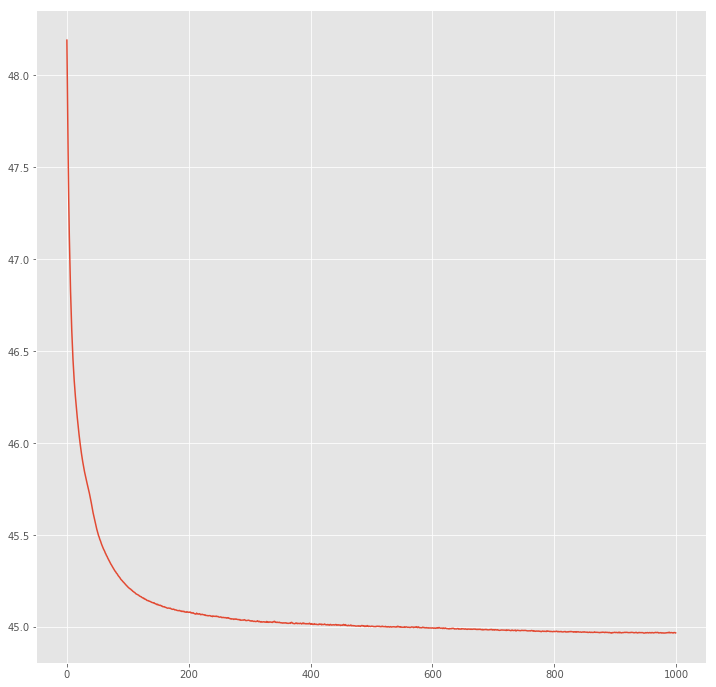

In [51]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist1['val_loss'])
plt.show()

In [52]:
y_experi_test=np.array(y_test).reshape(len(y_test), max_len, 17)

import the metrics for model performance

In [53]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

build the function for transfer the vector back to lable

In [54]:
def pred3label(pred):
    
    #reverse!
    
    idx2tag = {i: w for w, i in tag2idx.items()}
    
    #label into list
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [ ]:
#get the label
pred_labels_3 = pred3label(test_pred)
test_labels_3 = pred3label(y_experi_test)

In [55]:
#metrics and report, print out the report
def evaluation(test_labels, pred_labels):
    print(classification_report(test_labels, pred_labels))  

evaluation(test_labels_3, pred_labels_3)

                 precision    recall  f1-score   support

        Amenity       0.31      0.39      0.35       167
         Rating       0.29      0.16      0.21        49
       Location       0.31      0.31      0.31       236
Restaurant_Name       0.25      0.19      0.22       124
          Hours       0.15      0.05      0.08        55
          Price       0.20      0.23      0.22        43
        Cuisine       0.36      0.57      0.45       164
           Dish       0.50      0.13      0.21        93

    avg / total       0.31      0.31      0.29       931



show accuracy

In [56]:
from seqeval.metrics import accuracy_score
print("Accuracy_score: {:.1%}".format(accuracy_score(test_labels_3, pred_labels_3)))

Accuracy_score: 82.2%


# 2.3 Comparison to baseline model

## Baseline Model: Word level NN model with Bi-LSTM-CRF

In [ ]:
# the origninal bilstm

In [57]:
def model_biLSTM_CRF(max_len, n_words, n_tags):
    
    #input
    input = Input(shape=(max_len,))
    #embedding
    embed = Embedding(input_dim=n_words + 1, output_dim=20,
                      input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
    #bilstm
    lstm = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1))(embed)
    tdb = TimeDistributed(Dense(50, activation="relu"))(lstm)
    
    #crf
    crf = CRF(n_tags,sparse_target=False)
    out = crf(tdb)  # output
    
    model = Model(input, out)
    
    #using rmsprop
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

In [58]:
model= model_biLSTM_CRF(max_len, n_words, n_tags)

/Users/jianwenliu/anaconda3/envs/deepAI/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/jianwenliu/anaconda3/envs/deepAI/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 20)            32660     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 100)           28400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 15, 17)            1190      
Total params: 67,300
Trainable params: 67,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train and pred,get history and pred back
def train_base_model(batch_size= 32, epochs=30, X_train= X_train, y_train= y_train, X_test= X_test):
    
    #train model
    history = model.fit(X_train, np.array(y_train), batch_size= batch_size, epochs= epochs,
                        validation_split=0.1, verbose=1)    
    #prediction
    test_pred = model.predict(X_test, verbose=1)
    return test_pred,history

In [59]:
# train the model, get the prediction  
batch_size=32
epochs=30
test_pred,history= train_base_model(batch_size, epochs)

Train on 957 samples, validate on 107 samples
Epoch 1/30
957/957 [==============================] - 5s 5ms/step - loss: 1.5422 - crf_viterbi_accuracy: 0.7220 - val_loss: 1.0833 - val_crf_viterbi_accuracy: 0.7639
Epoch 2/30
957/957 [==============================] - 1s 1ms/step - loss: 1.1141 - crf_viterbi_accuracy: 0.7514 - val_loss: 1.0208 - val_crf_viterbi_accuracy: 0.7639
Epoch 3/30
957/957 [==============================] - 1s 2ms/step - loss: 1.0444 - crf_viterbi_accuracy: 0.7514 - val_loss: 0.9565 - val_crf_viterbi_accuracy: 0.7639
Epoch 4/30
957/957 [==============================] - 2s 2ms/step - loss: 0.9896 - crf_viterbi_accuracy: 0.7514 - val_loss: 0.8943 - val_crf_viterbi_accuracy: 0.7639
Epoch 5/30
957/957 [==============================] - 1s 1ms/step - loss: 0.9317 - crf_viterbi_accuracy: 0.7514 - val_loss: 0.8362 - val_crf_viterbi_accuracy: 0.7639
Epoch 6/30
957/957 [==============================] - 1s 2ms/step - loss: 0.8632 - crf_viterbi_accuracy: 0.7514 - val_loss: 

pandas df

In [60]:
hist = pd.DataFrame(history.history)

In [61]:
hist.head(5)

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,1.083303,0.763863,1.542234,0.721978
1,1.020758,0.763863,1.114085,0.751445
2,0.956547,0.763863,1.044449,0.751445
3,0.894256,0.763863,0.989563,0.751445
4,0.836162,0.763863,0.931713,0.751445


Plot the training loss

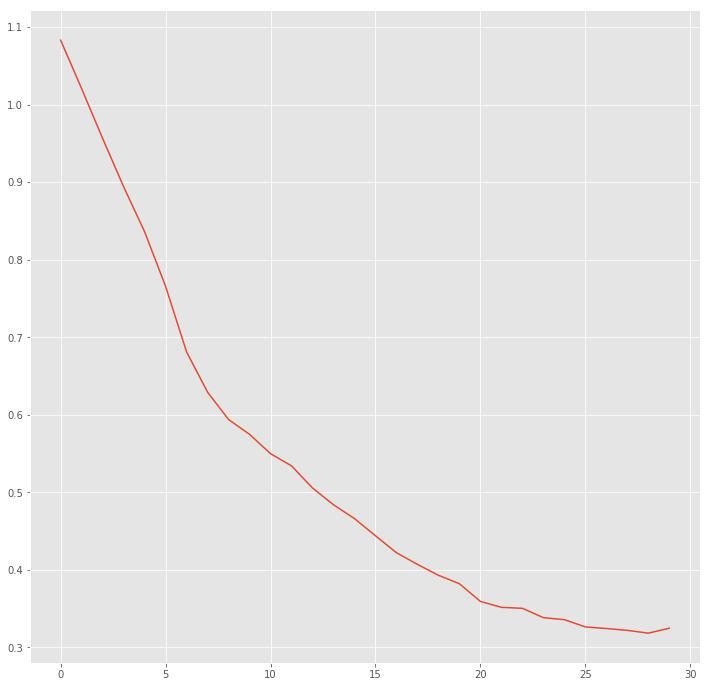

In [62]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist['val_loss'])
plt.show()

In [63]:
# this section is similar to word + char NN.
# reverse from vect to label
def pred2label(pred):
    idx2tag = {i: w for w, i in tag2idx.items()}
    
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


In [ ]:
#get the label back
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

evaluation

In [64]:
def evaluation(test_labels, pred_labels):
    #print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))  
    print(classification_report(test_labels, pred_labels))  

evaluation(test_labels, pred_labels)

                 precision    recall  f1-score   support

        Amenity       0.46      0.49      0.47       167
         Rating       0.46      0.43      0.44        49
       Location       0.70      0.69      0.69       236
Restaurant_Name       0.40      0.35      0.37       124
          Hours       0.42      0.44      0.43        55
          Price       0.53      0.37      0.44        43
        Cuisine       0.50      0.64      0.56       164
           Dish       0.50      0.30      0.38        93

    avg / total       0.52      0.52      0.52       931



# 3 Conclusion

We built a word-char level NN model and applied the model on named entity recognition on short queries. From the experiment result, we have conclusions as follows:

First, the model performance of our model on named entity recognition on queries is acceptable, even though they are not high. By check precision, recall and F1 score, we found out basically all the metrics are about 0.35. These results are still smaller than that on formal text. The reasons are as follows: 1) the queries are short. This feature leads to the bad performance on LSTM layer. Since we use LSTM layer to try to capture the sequential information in sentences, the shortness of queries obstructs this consistency in text and may fail our attempt. 2) the queries violate formal syntactical rules. As people who propose queries often gave syntactically wrong sentences, the sequential relation of named entities may not obey the formal syntactical rules. This may destruct our CRF layer performance and further model performance.

Second, according to running time of our algorithm, it is slower than the common Bi-LSTM-CRF model on word level. There are several potential reasons. Firstly, we build a model including two LSTM layer and CRF layer. This means we have more parameters train compared with common NN models. The training on parameters is costly. Another reason that our model is slow is that we concatenate the representation of character vector and representation of word vector as input to the second layer Bi-LSTM. This concatenati built a longer vector than plain word vectors, which takes more time to train.